# Basic Usage

1. install client and connect to the API

In [ ]:
#%pip install ..
%pip install stability-sdk

In [1]:
import getpass, os

# NB: host url is not prepended with \"https\" nor does it have a trailing slash.
os.environ['STABILITY_HOST'] = 'grpc.stability.ai:443'

# To get your API key, visit https://beta.dreamstudio.ai/membership
os.environ['STABILITY_KEY'] = getpass.getpass('Enter your API Key')

In [2]:
import io
import os
import warnings

from IPython.display import display
from PIL import Image
from stability_sdk import client
import stability_sdk.interfaces.gooseai.generation.generation_pb2 as generation


stability_api = client.StabilityInference(
    key=os.environ['STABILITY_KEY'], 
    verbose=True,
)

2. Submit a request to generate a single image from a text prompt

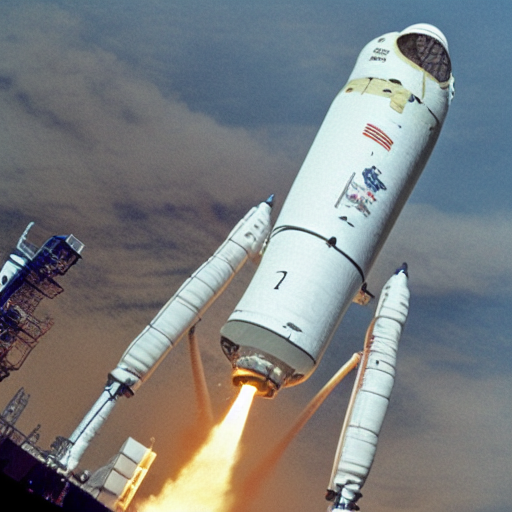

In [3]:
# the object returned is a python generator
answers = stability_api.generate(
    prompt="houston, we are a 'go' for launch!",
    seed=34567, # if provided, specifying a random seed makes results deterministic
    steps=20, # defaults to 30 if not specified
)

# iterating over the generator produces the api response
for resp in answers:
    for artifact in resp.artifacts:
        if artifact.finish_reason == generation.FILTER:
            warnings.warn(
                "Your request activated the API's safety filters and could not be processed."
                "Please modify the prompt and try again.")
        if artifact.type == generation.ARTIFACT_IMAGE:
            img = Image.open(io.BytesIO(artifact.binary))
            display(img)

# Intermediate usage

3. (new!) An "init" image can be provided for text-driven image modification. To demonstrate, we can convert the image we just generated to a colored pencil sketch

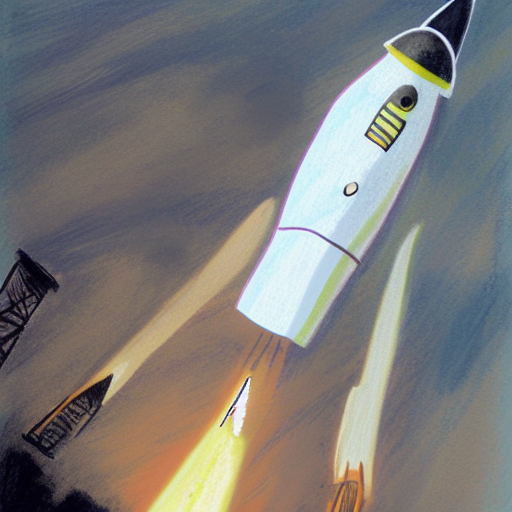

In [4]:
answers = stability_api.generate(
    prompt="childrens crayon drawing of a rocket launch",
    init_image=img,
    seed=54321, # if we're passing in an image generated by SD, you may get better results by providing a different seed value than was used to generate the image
    start_schedule=0.6, # this controls the "strength" of the prompt relative to the init image
)

# iterating over the generator produces the api response
for resp in answers:
    for artifact in resp.artifacts:
        if artifact.finish_reason == generation.FILTER:
            warnings.warn(
                "Your request activated the API's safety filters and could not be processed."
                "Please modify the prompt and try again.")
        if artifact.type == generation.ARTIFACT_IMAGE:
            img2 = Image.open(io.BytesIO(artifact.binary))
            display(img2)

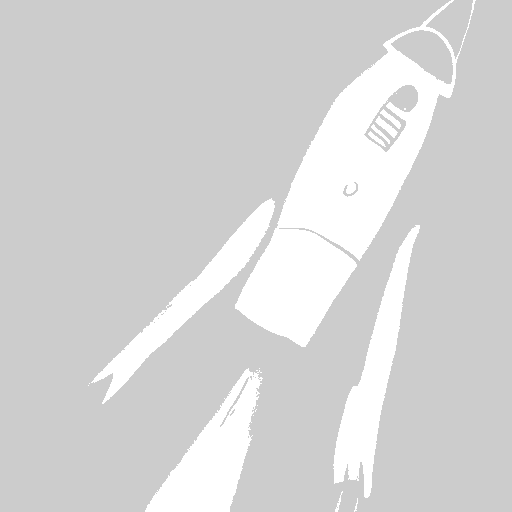

In [5]:
# we can make a rough mask by thresholding the grayscaled image

import numpy as np

img2_grayscale = img2.convert('L')
img2_a = np.array(img2_grayscale)

mask = np.array(img2_grayscale)
mask[img2_a<150] = 0  # this is the area that will get painted, will show up black below
mask[img2_a>=150] = 1 # this is the protected area, will show up white below

strength = .2  # this controls the "strength" of the prompt relative to the init image

d = int(255 * (1-strength))
mask *= 255-d # convert from range [0,1] to [0,255]
mask += d

mask = Image.fromarray(mask)
mask

/home/dmarx/.local/share/virtualenvs/dmarx-je5LfYh2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


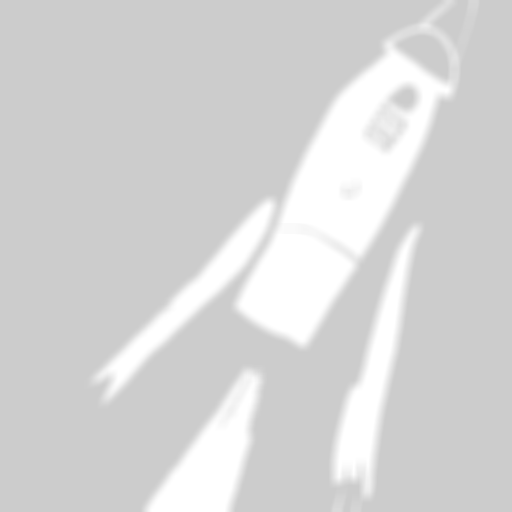

In [6]:
# fuzzing the mask edges generally improves synthesis results

from torchvision.transforms import GaussianBlur

blur = GaussianBlur(11,20)
mask = blur(mask)
mask

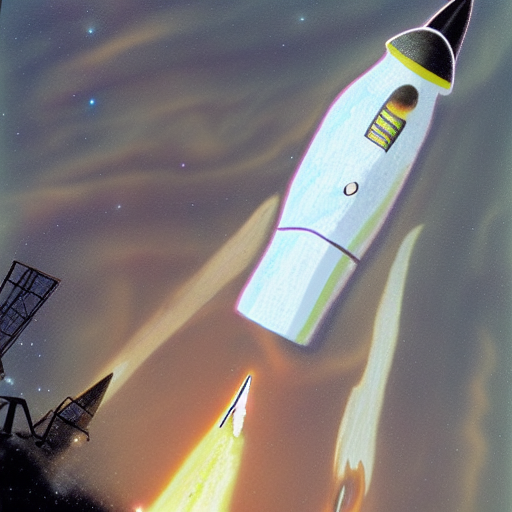

In [8]:
# now, let's send our drawing into space
answers = stability_api.generate(
    prompt="beautiful galaxies and stars in hubble telescope deep field",
    init_image=img2,
    mask_image=mask,
    seed=12345, # if we're passing in an image generated by SD, you may get better results by providing a different seed value than was used to generate the image
    start_schedule=1,
)

for resp in answers:
    for artifact in resp.artifacts:
        if artifact.finish_reason == generation.FILTER:
            warnings.warn(
                "Your request activated the API's safety filters and could not be processed."
                "Please modify the prompt and try again.")
        if artifact.type == generation.ARTIFACT_IMAGE:
            img3 = Image.open(io.BytesIO(artifact.binary))
            display(img3)

In [ ]:
# we can improve our image result by introducing clip guidance into the request. this takes longer (and costs more compute) but often yields better results.
# clip guidance is built with several presets optimized for speed or quality, but clip can be controlled more precisely with a variety of other params

answers = stability_api.generate(
    prompt="houston, we are a 'go' for launch!",
    seed=34567,  
    steps=35, # minimum of 35 steps recommended when using CLIP
    guidance_preset = generation.GUIDANCE_PRESET_FAST_BLUE
)

for resp in answers:
    for artifact in resp.artifacts:
        if artifact.finish_reason == generation.FILTER:
            warnings.warn(
                "Your request activated the API's safety filters and could not be processed."
                "Please modify the prompt and try again.")
        if artifact.type == generation.ARTIFACT_IMAGE:
            img4 = Image.open(io.BytesIO(artifact.binary))
            print('GUIDANCE: FAST-BLUE:')
            display(img4)

answers = stability_api.generate(
    prompt="houston, we are a 'go' for launch!",
    seed=34567, 
    steps=35, 
    guidance_preset = generation.GUIDANCE_PRESET_SLOWER
)

for resp in answers:
    for artifact in resp.artifacts:
        if artifact.finish_reason == generation.FILTER:
            warnings.warn(
                "Your request activated the API's safety filters and could not be processed."
                "Please modify the prompt and try again.")
        if artifact.type == generation.ARTIFACT_IMAGE:
            img5 = Image.open(io.BytesIO(artifact.binary))
            print('GUIDANCE: SLOWER:')
            display(img5)

In [ ]:
# Upscaling
answers = stability_api.upscale(
    init_image=img3
)

for resp in answers:
    for artifact in resp.artifacts:
        if artifact.finish_reason == generation.FILTER:
            warnings.warn(
                "Your request activated the API's safety filters and could not be processed."
                "Please submit a different image and try again.")
        if artifact.type == generation.ARTIFACT_IMAGE:
            img3 = Image.open(io.BytesIO(artifact.binary))
            display(img3)